In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import matplotlib.pyplot as plt


In [3]:
def Dataset_Loader(validation_set_size=0.2, seed=25):
    """
    Loads and preprocesses the MNIST dataset using KERAS

    Args:
        validation_set_size (float): The size of the validation set as a fraction of the training set.
        seed (int): The random seed for data splitting.

    Returns:
        Tuple of torch tensors: (X_train, Y_train, X_val, Y_val, X_test, Y_test)
            - X_train (torch.Tensor): Training data features (input), shape (784, m_train).
            - Y_train (torch.Tensor): Training data labels (output), shape (10, m_train).
            - X_val (torch.Tensor): Validation data features (input), shape (784, m_val).
            - Y_val (torch.Tensor): Validation data labels (output), shape (10, m_val).
            - X_test (torch.Tensor): Testing data features (input), shape (784, m_test).
            - Y_test (torch.Tensor): Testing data labels (output), shape (10, m_test).
    """
    from keras.datasets import mnist
    (train_X, train_y), (test_X, test_y) = mnist.load_data()

    # Preprocess
    train_X = train_X.reshape(train_X.shape[0], -1) / 255
    X_test = test_X.reshape(test_X.shape[0], -1) / 255
    train_y = np.eye(10)[train_y]
    Y_test = np.eye(10)[test_y]

    X_train, X_val, Y_train, Y_val = train_test_split(
        train_X, train_y, test_size=validation_set_size, random_state=seed
    )

    X_train = torch.tensor(X_train.T, dtype=torch.float32)
    Y_train = torch.tensor(Y_train.T, dtype=torch.float32)
    X_val = torch.tensor(X_val.T, dtype=torch.float32)
    Y_val = torch.tensor(Y_val.T, dtype=torch.float32)
    X_test = torch.tensor(X_test.T, dtype=torch.float32)
    Y_test = torch.tensor(Y_test.T, dtype=torch.float32)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test
# Load data
X_train, Y_train, X_val, Y_val, X_test, Y_test = Dataset_Loader()

2024-11-29 09:17:57.373515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732864678.396233 3426503 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732864678.637001 3426503 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 09:18:01.299401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shapes:
X_train: torch.Size([784, 48000]), Y_train: torch.Size([10, 48000])
X_val: torch.Size([784, 12000]), Y_val: torch.Size([10, 12000])
X_test: torch.Size([784, 10000]), Y_test: torch.Size([10, 10000])


In [ ]:
def initialize_parameters(layer_dims):
    """
    Initialize parameters W and b for each layer.

    Arguments:
    layer_dims -- List containing the dimensions of each layer.

    Returns:
    parameters -- Dictionary of initialized parameters.
    """
    parameters = {}
    L = len(layer_dims)  # Number of layers including input layer

    for l in range(1, L):
        # He initialization
        std_dev = torch.sqrt(torch.tensor(2.0 / layer_dims[l-1], dtype=torch.float32))
        parameters['W' + str(l)] = torch.randn(layer_dims[l], layer_dims[l-1], dtype=torch.float32) * std_dev
        parameters['b' + str(l)] = torch.zeros((layer_dims[l], 1), dtype=torch.float32)

    return parameters

def linear_forward(A, W, b):
    """
    Compute the linear part of a layer's forward propagation.

    Arguments:
    A -- Activations from previous layer (or input data).
    W -- Weights matrix for current layer.
    b -- Bias vector for current layer.

    Returns:
    Z -- Linear component of activation function.
    linear_cache -- Tuple containing (A, W, b) for backward pass.
    """
    Z = torch.matmul(W, A) + b
    linear_cache = (A, W, b)
    return Z, linear_cache

def relu(Z):
    """
    Apply the ReLU activation function.

    Arguments:
    Z -- Linear component input.

    Returns:
    A -- Post-activation output.
    activation_cache -- Returns Z for backward pass.
    """
    A = torch.relu(Z)
    activation_cache = Z
    return A, activation_cache

def softmax(Z):
    """
    Apply the softmax activation function.

    Arguments:
    Z -- Linear component input.

    Returns:
    A -- Post-activation output (probabilities).
    activation_cache -- Returns Z for backward pass.
    """
    # For numerical stability
    Z_max = torch.max(Z, dim=0, keepdim=True)[0]
    exp_Z = torch.exp(Z - Z_max)
    A = exp_Z / torch.sum(exp_Z, dim=0, keepdim=True)
    activation_cache = Z
    return A, activation_cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement forward propagation for LINEAR->ACTIVATION layer.

    Arguments:
    A_prev -- Activations from previous layer.
    W -- Weights matrix.
    b -- Bias vector.
    activation -- Activation function to use ("relu" or "softmax").

    Returns:
    A -- Post-activation output.
    cache -- Tuple containing linear_cache and activation_cache.
    """
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
    else:
        raise Exception("Unsupported activation function")

    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters, use_batchnorm=False):
    """
    Implement forward propagation for the entire network.

    Arguments:
    X -- Input data.
    parameters -- Dictionary of parameters.
    use_batchnorm -- Boolean flag for batch normalization.

    Returns:
    AL -- Output of the last layer.
    caches -- List of caches from each layer.
    """
    caches = []
    A = X
    L = len(parameters) // 2  # Number of layers in the network

    # Loop through layers 1 to L-1
    for l in range(1, L):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, activation="relu")
        
        if use_batchnorm:
            A = apply_batchnorm(A)
        
        caches.append(cache)
    
    # Output layer
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    AL, cache = linear_activation_forward(A, W, b, activation="softmax")
    caches.append(cache)
    
    return AL, caches

def compute_cost(AL, Y, parameters, lambd):
    """
    Computes the cost function with L2 regularization.

    Args:
        AL (torch.Tensor): Probability vector corresponding to the label predictions, shape (num_classes, m).
        Y (torch.Tensor): True "label" vector, shape (num_classes, m).
        parameters (dict): Dictionary containing the model parameters.
        lambd (float): Regularization parameter.

    Returns:
        cost (torch.Tensor): Cross-entropy cost with L2 regularization.
    """
    m = Y.shape[1]

    # Cross-entropy loss
    cross_entropy_cost = -torch.sum(Y * torch.log(AL + 1e-8)) / m

    # L2 regularization cost
    L2_regularization_cost = 0
    if lambd != 0:
        L = len(parameters) // 2  # Number of layers
        for l in range(1, L + 1):
            L2_regularization_cost += torch.sum(torch.square(parameters["W" + str(l)]))
        L2_regularization_cost = (lambd / (2 * m)) * L2_regularization_cost

    cost = cross_entropy_cost + L2_regularization_cost
    return cost

def linear_backward(dZ, cache):
    """
    Compute gradients for the linear part.

    Arguments:
    dZ -- Gradient of the cost with respect to Z.
    cache -- Tuple of (A_prev, W, b).

    Returns:
    dA_prev -- Gradient with respect to A_prev.
    dW -- Gradient with respect to W.
    db -- Gradient with respect to b.
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    # Compute gradients
    dW = torch.matmul(dZ, A_prev.t()) / m
    db = torch.sum(dZ, dim=1, keepdim=True) / m
    dA_prev = torch.matmul(W.t(), dZ)

    return dA_prev, dW, db

def relu_backward(dA, activation_cache):
    """
    Compute backward propagation for ReLU.

    Arguments:
    dA -- Post-activation gradient.
    activation_cache -- Cached Z from forward pass.

    Returns:
    dZ -- Gradient of the cost with respect to Z.
    """
    Z = activation_cache
    dZ = dA.clone()
    dZ[Z <= 0] = 0
    return dZ

def softmax_backward(AL, Y):
    """
    Compute backward propagation for Softmax.

    Arguments:
    AL -- Output of softmax (probabilities).
    Y -- True labels.

    Returns:
    dZ -- Gradient of the cost with respect to Z.
    """
    dZ = AL - Y  # For softmax with cross-entropy loss
    return dZ

def linear_activation_backward(dA, cache, activation):
    """
    Implement backward propagation for LINEAR->ACTIVATION layer.

    Arguments:
    dA -- Post-activation gradient.
    cache -- Tuple of (linear_cache, activation_cache).
    activation -- Activation function used ("relu" or "softmax").

    Returns:
    dA_prev -- Gradient with respect to A_prev.
    dW -- Gradient with respect to W.
    db -- Gradient with respect to b.
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    else:
        raise Exception("Unsupported activation function")

    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement backward propagation for the entire network.

    Arguments:
    AL -- Probability vector from forward propagation.
    Y -- True labels.
    caches -- List of caches from forward propagation.

    Returns:
    grads -- Dictionary with gradients.
    """
    grads = {}
    L = len(caches)  # Number of layers
    Y = Y.reshape(AL.shape)

    # Initialize backpropagation for output layer
    current_cache = caches[L-1]
    dZ = softmax_backward(AL, Y)
    linear_cache, _ = current_cache
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = \
        linear_backward(dZ, linear_cache)

    # Loop from L-2 to 0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = \
            linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent.

    Arguments:
    parameters -- Dictionary containing parameters.
    grads -- Dictionary containing gradients.
    learning_rate -- Learning rate.

    Returns:
    parameters -- Updated parameters.
    """
    L = len(parameters) // 2  # Number of layers

    for l in range(1, L+1):
        parameters['W' + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads["db" + str(l)]

    return parameters

def apply_batchnorm(A):
    """
    Apply batch normalization to activations.

    Arguments:
    A -- Activations of the layer.

    Returns:
    NA -- Normalized activations.
    """
    epsilon = 1e-5  # Small constant to avoid division by zero
    mu = torch.mean(A, dim=1, keepdim=True)
    var = torch.var(A, dim=1, keepdim=True, unbiased=False)
    NA = (A - mu) / torch.sqrt(var + epsilon)
    return NA

def L_layer_model(X_train, Y_train, X_val, Y_val, layers_dims, learning_rate=0.009,
                  num_iterations=10000, batch_size=64, use_batchnorm=False,
                  lambd=0.0, stopping_steps=100):
    parameters = initialize_parameters(layers_dims)
    costs = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    steps_since_improvement = 0
    total_steps = 0
    m = X_train.shape[1]
    num_batches = m // batch_size
    epochs = 0

    while total_steps < num_iterations:
        epochs += 1 
        permutation = torch.randperm(m)
        X_shuffled = X_train[:, permutation]
        Y_shuffled = Y_train[:, permutation]

        for j in range(num_batches):
            total_steps += 1
            start = j * batch_size
            end = start + batch_size
            X_batch = X_shuffled[:, start:end]
            Y_batch = Y_shuffled[:, start:end]

            # Forward propagation
            AL, caches = L_model_forward(X_batch, parameters, use_batchnorm)

            # Compute cost with regularization
            cost = compute_cost(AL, Y_batch, parameters, lambd)

            # Backward propagation
            grads = L_model_backward(AL, Y_batch, caches)

            # Update parameters
            parameters = update_parameters(parameters, grads, learning_rate)

            # Compute validation accuracy
            val_accuracy = predict(X_val, Y_val, parameters, use_batchnorm=use_batchnorm)
            if total_steps % 100 == 0:
                # Compute training accuracy on the current batch
                train_accuracy = predict(X_batch, Y_batch, parameters, use_batchnorm=use_batchnorm)
                train_accuracies.append((total_steps, train_accuracy))
                val_accuracies.append((total_steps, val_accuracy))
                costs.append((total_steps, cost.item()))
                print(f"After {total_steps} steps: cost = {cost.item()} , Training accuracy = {train_accuracy:.2f}% , Validation accuracy = {val_accuracy:.2f}%")

            # Early stopping based on validation accuracy
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                steps_since_improvement = 0
            else:
                steps_since_improvement += 1  

            if steps_since_improvement >= stopping_steps and epochs >= 10:
                print(f"Early stopping at step {total_steps} due to no improvement in validation accuracy.")
                return parameters, costs, train_accuracies, val_accuracies, total_steps

    return parameters, costs, train_accuracies, val_accuracies, total_steps

def predict(X, Y, parameters, use_batchnorm=False):
    """
    Make predictions using the trained model.

    Arguments:
    X -- Input data.
    Y -- True labels.
    parameters -- Trained parameters.

    Returns:
    accuracy -- Accuracy of the model.
    """
    AL, _ = L_model_forward(X, parameters, use_batchnorm=use_batchnorm)
    predictions = torch.argmax(AL, dim=0)
    labels = torch.argmax(Y, dim=0)
    accuracy = torch.mean((predictions == labels).float()) * 100
    return accuracy.item()


After 100 steps: cost = 2.017472505569458 , Training accuracy = 28.12% , Validation accuracy = 27.12%
After 200 steps: cost = 1.7943065166473389 , Training accuracy = 35.55% , Validation accuracy = 36.08%
After 300 steps: cost = 1.6206823587417603 , Training accuracy = 44.14% , Validation accuracy = 40.68%
After 400 steps: cost = 1.4219380617141724 , Training accuracy = 49.22% , Validation accuracy = 42.90%
After 500 steps: cost = 1.3868895769119263 , Training accuracy = 43.36% , Validation accuracy = 45.25%
After 600 steps: cost = 1.241807460784912 , Training accuracy = 55.08% , Validation accuracy = 47.53%
After 700 steps: cost = 1.2362000942230225 , Training accuracy = 53.91% , Validation accuracy = 51.82%
After 800 steps: cost = 1.1176578998565674 , Training accuracy = 62.89% , Validation accuracy = 58.88%
After 900 steps: cost = 1.025376796722412 , Training accuracy = 69.14% , Validation accuracy = 64.38%
After 1000 steps: cost = 1.0319569110870361 , Training accuracy = 66.80% , V

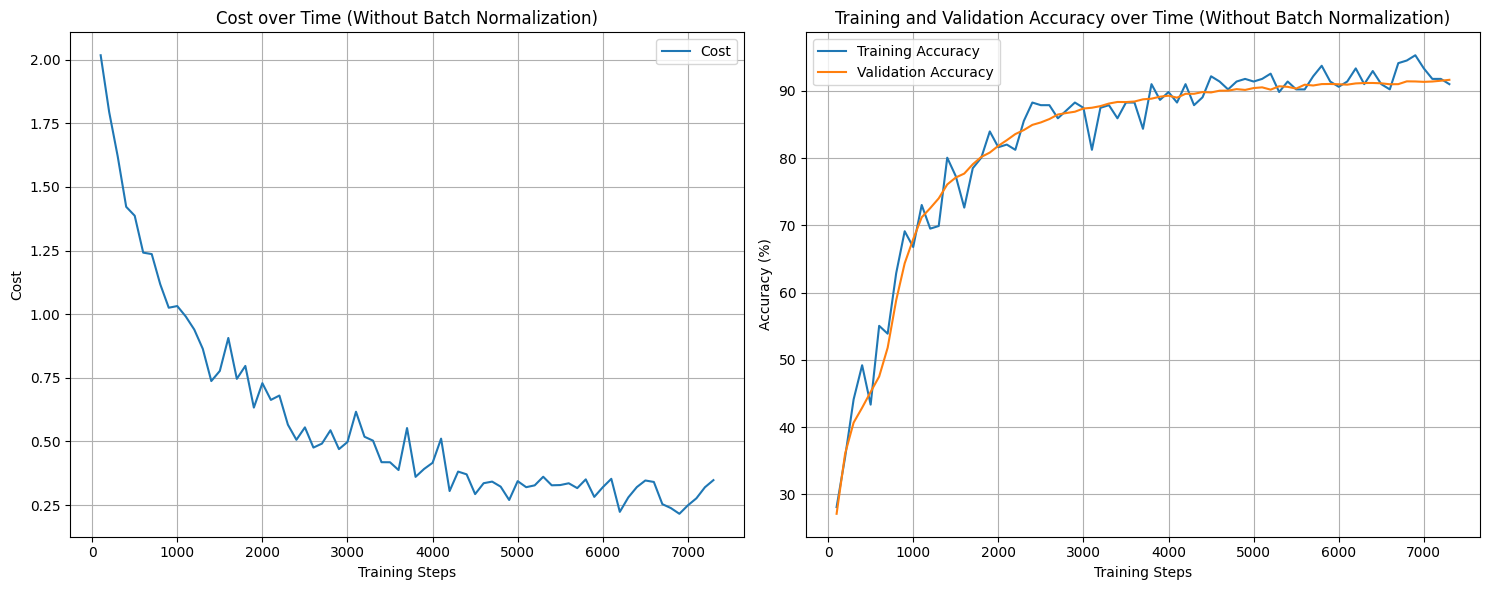

In [ ]:
import time  # Import the time module to measure running time

# Training Without Batch Normalization 

# Define layer dimensions
layers_dims = [784, 20, 7, 5, 10]  # Example layer dimensions

# Start timing the training process
start_time = time.time()

# Train the model without batch normalization
parameters_baseline, costs_baseline, train_acc_baseline, val_acc_baseline, steps = L_layer_model(
    X_train, Y_train, X_val, Y_val, layers_dims,
    learning_rate=0.009, num_iterations=100000,
    batch_size=256, use_batchnorm=False, lambd=0.0, stopping_steps=100
)

# End timing
end_time = time.time()
training_time = end_time - start_time  # Calculate the running time in seconds

# Evaluate on test set
test_accuracy_baseline = predict(X_test, Y_test, parameters_baseline)

# Print final accuracies and running time
print(f"Final Training Accuracy: {train_acc_baseline[-1][1]:.2f}%")
print(f"Final Validation Accuracy: {val_acc_baseline[-1][1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracy_baseline:.2f}% , Number of Iterations: {steps}")
print(f"Total Training Time: {training_time:.2f} seconds")

# Adjust the plots to be side by side
import matplotlib.pyplot as plt

steps_cost, cost_values = zip(*costs_baseline)
steps_train_acc, train_acc_values = zip(*train_acc_baseline)
steps_val_acc, val_acc_values = zip(*val_acc_baseline)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(steps_cost, cost_values, label='Cost')
axes[0].set_xlabel('Training Steps')
axes[0].set_ylabel('Cost')
axes[0].set_title('Cost over Time (Without Batch Normalization)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(steps_train_acc, train_acc_values, label='Training Accuracy')
axes[1].plot(steps_val_acc, val_acc_values, label='Validation Accuracy')
axes[1].set_xlabel('Training Steps')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy over Time (Without Batch Normalization)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()



After 100 steps: cost = 2.5153262615203857 , Training accuracy = 15.62% , Validation accuracy = 19.77%
After 200 steps: cost = 2.2326087951660156 , Training accuracy = 21.09% , Validation accuracy = 26.50%
After 300 steps: cost = 2.0544686317443848 , Training accuracy = 26.56% , Validation accuracy = 30.75%
After 400 steps: cost = 1.9128262996673584 , Training accuracy = 32.03% , Validation accuracy = 32.43%
After 500 steps: cost = 1.7918856143951416 , Training accuracy = 36.72% , Validation accuracy = 34.38%
After 600 steps: cost = 1.624979853630066 , Training accuracy = 49.22% , Validation accuracy = 39.47%
After 700 steps: cost = 1.6775791645050049 , Training accuracy = 42.19% , Validation accuracy = 43.40%
After 800 steps: cost = 1.6013789176940918 , Training accuracy = 46.88% , Validation accuracy = 45.52%
After 900 steps: cost = 1.5626966953277588 , Training accuracy = 42.97% , Validation accuracy = 47.04%
After 1000 steps: cost = 1.5107836723327637 , Training accuracy = 48.44% ,

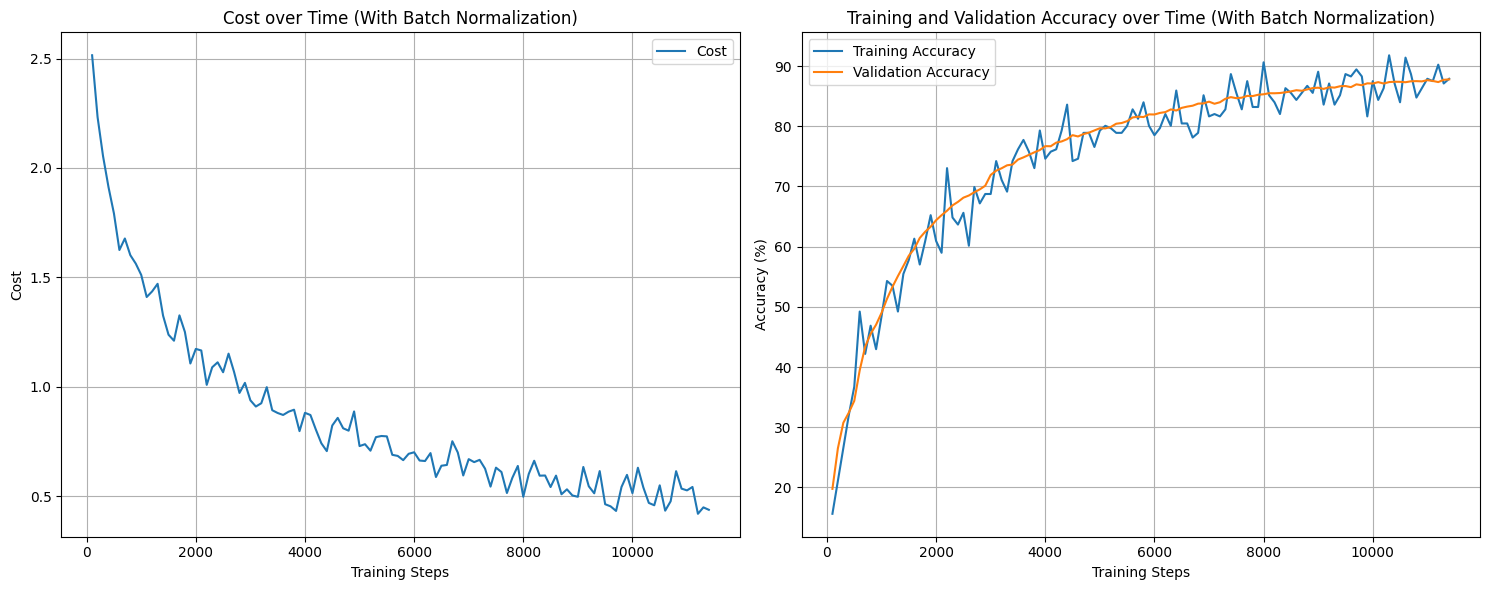

In [ ]:
# Training With Batch Normalization
layers_dims = [784, 20, 7, 5, 10]  # Example layer dimensions

start_time = time.time()
# Train the model with batch normalization
parameters_batchnorm, costs_batchnorm, train_acc_batchnorm, val_acc_batchnorm, steps = L_layer_model(
    X_train, Y_train, X_val, Y_val, layers_dims,
    learning_rate=0.009, num_iterations=100000,
    batch_size=256, use_batchnorm=True, lambd=0.0, stopping_steps=100
)

# End timing
end_time = time.time()
training_time = end_time - start_time  # Calculate the running time in seconds

# Evaluate on test set
test_accuracy_batchnorm = predict(X_test, Y_test, parameters_batchnorm, use_batchnorm=True)

# Print final accuracies
print(f"Final Training Accuracy: {train_acc_batchnorm[-1][1]:.2f}%")
print(f"Final Validation Accuracy: {val_acc_batchnorm[-1][1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracy_batchnorm:.2f}% , Number of Iterations: {steps}")
print(f"Total Training Time: {training_time:.2f} seconds")


# Adjust the plots to be side by side
import matplotlib.pyplot as plt

steps_cost_bn, cost_values_bn = zip(*costs_batchnorm)
steps_train_acc_bn, train_acc_values_bn = zip(*train_acc_batchnorm)
steps_val_acc_bn, val_acc_values_bn = zip(*val_acc_batchnorm)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot cost over time
axes[0].plot(steps_cost_bn, cost_values_bn, label='Cost')
axes[0].set_xlabel('Training Steps')
axes[0].set_ylabel('Cost')
axes[0].set_title('Cost over Time (With Batch Normalization)')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation accuracy over time
axes[1].plot(steps_train_acc_bn, train_acc_values_bn, label='Training Accuracy')
axes[1].plot(steps_val_acc_bn, val_acc_values_bn, label='Validation Accuracy')
axes[1].set_xlabel('Training Steps')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy over Time (With Batch Normalization)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


After 100 steps: cost = 2.1285810470581055 , Training accuracy = 20.31% , Validation accuracy = 24.43%
After 200 steps: cost = 1.9254838228225708 , Training accuracy = 39.84% , Validation accuracy = 37.62%
After 300 steps: cost = 1.7659335136413574 , Training accuracy = 46.09% , Validation accuracy = 46.86%
After 400 steps: cost = 1.7100316286087036 , Training accuracy = 43.36% , Validation accuracy = 50.12%
After 500 steps: cost = 1.5059601068496704 , Training accuracy = 54.30% , Validation accuracy = 52.53%
After 600 steps: cost = 1.3998212814331055 , Training accuracy = 58.59% , Validation accuracy = 55.83%
After 700 steps: cost = 1.4735468626022339 , Training accuracy = 58.59% , Validation accuracy = 58.03%
After 800 steps: cost = 1.2728341817855835 , Training accuracy = 64.06% , Validation accuracy = 60.86%
After 900 steps: cost = 1.3070603609085083 , Training accuracy = 60.94% , Validation accuracy = 62.17%
After 1000 steps: cost = 1.302426815032959 , Training accuracy = 62.50% ,

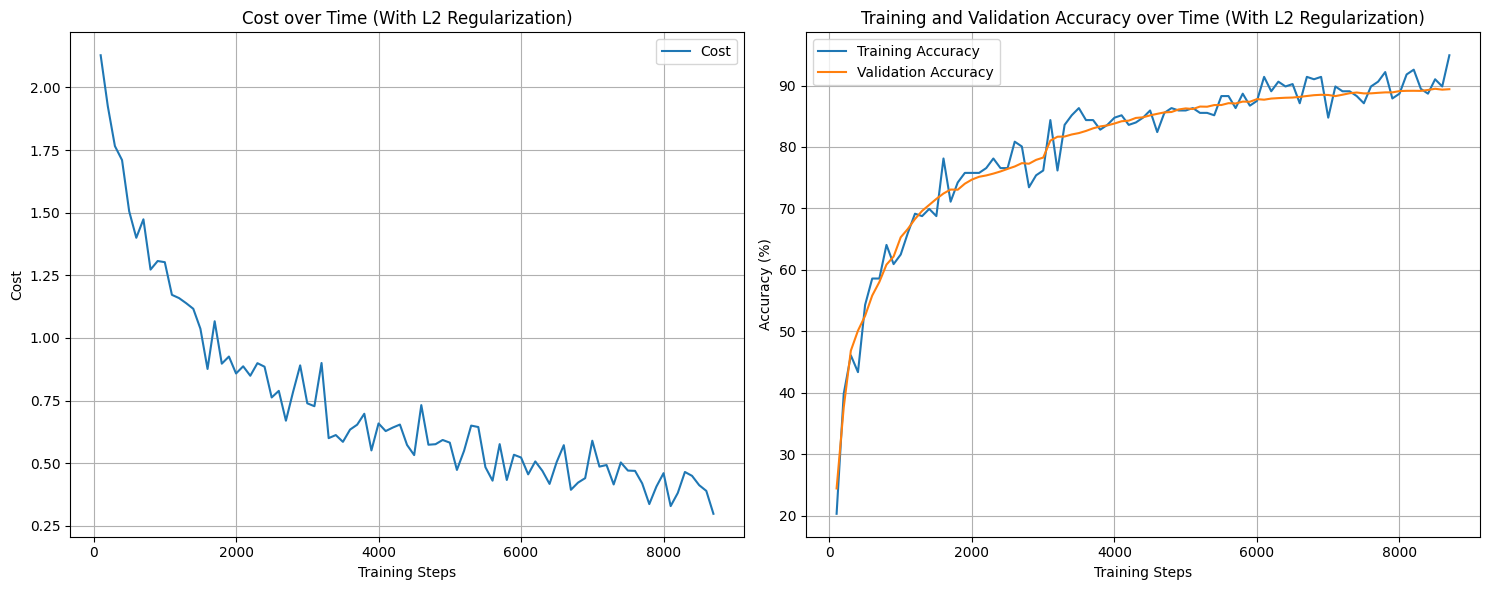

In [ ]:
# Training With L2 Regularization

# Set regularization parameter
lambd = 0.1  # You can adjust this value as needed

start_time = time.time()

# Train the model with L2 regularization
parameters_l2, costs_l2, train_acc_l2, val_acc_l2, steps = L_layer_model(
    X_train, Y_train, X_val, Y_val, layers_dims,
    learning_rate=0.009, num_iterations=100000,
    batch_size=256, use_batchnorm=False, lambd=lambd, stopping_steps=100
)


# End timing
end_time = time.time()
training_time = end_time - start_time  # Calculate the running time in seconds

# Evaluate on test set
test_accuracy_l2 = predict(X_test, Y_test, parameters_l2)
print(f"Test Accuracy (With L2 Regularization): {test_accuracy_l2:.2f}%, Number of Iterations: {steps}")

# Print final accuracies
print(f"Final Training Accuracy: {train_acc_l2[-1][1]:.2f}%")
print(f"Final Validation Accuracy: {val_acc_l2[-1][1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracy_l2:.2f}% , Number of Iterations: {steps}")
print(f"Total Training Time: {training_time:.2f} seconds")



# Adjust the plots to be side by side
import matplotlib.pyplot as plt

steps_cost_l2, cost_values_l2 = zip(*costs_l2)
steps_train_acc_l2, train_acc_values_l2 = zip(*train_acc_l2)
steps_val_acc_l2, val_acc_values_l2 = zip(*val_acc_l2)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot cost over time
axes[0].plot(steps_cost_l2, cost_values_l2, label='Cost')
axes[0].set_xlabel('Training Steps')
axes[0].set_ylabel('Cost')
axes[0].set_title('Cost over Time (With L2 Regularization)')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation accuracy over time
axes[1].plot(steps_train_acc_l2, train_acc_values_l2, label='Training Accuracy')
axes[1].plot(steps_val_acc_l2, val_acc_values_l2, label='Validation Accuracy')
axes[1].set_xlabel('Training Steps')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy over Time (With L2 Regularization)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [21]:
print(f"W1 withot L2 Regularization:\n {parameters_baseline['W1']}")
print(f"W1 with L2 Regularization:\n {parameters_l2['W1']}")
print(f"W2 withot L2 Regularization:\n {parameters_baseline['W2']}")
print(f"W2 with L2 Regularization:\n {parameters_l2['W2']}")
print(f"W3 withot L2 Regularization:\n {parameters_baseline['W3']}")
print(f"W3 with L2 Regularization:\n {parameters_l2['W3']}")
print(f"W4 withot L2 Regularization:\n {parameters_baseline['W4']}")
print(f"W4 with L2 Regularization:\n {parameters_l2['W4']}")

W1 withot L2 Regularization:
 tensor([[-0.0300, -0.0580, -0.0388,  ..., -0.0045,  0.0312,  0.0012],
        [ 0.0305,  0.0312, -0.0446,  ...,  0.0573,  0.0748, -0.0143],
        [-0.0165,  0.0205, -0.0075,  ...,  0.0367,  0.0467,  0.0878],
        ...,
        [ 0.0787, -0.0895, -0.0083,  ..., -0.0564, -0.0597, -0.0078],
        [ 0.0970, -0.1175, -0.0077,  ..., -0.0383, -0.0811, -0.0114],
        [-0.0406,  0.0945,  0.0017,  ..., -0.0081, -0.0174,  0.0262]])
W1 with L2 Regularization:
 tensor([[-0.0178,  0.0633,  0.0806,  ...,  0.0327,  0.0981,  0.0226],
        [ 0.0414, -0.1165, -0.0727,  ...,  0.0036,  0.0511,  0.0571],
        [-0.0671,  0.0512, -0.0183,  ...,  0.0460, -0.0028,  0.0200],
        ...,
        [ 0.0172,  0.0270,  0.0153,  ..., -0.0125,  0.0054,  0.0256],
        [ 0.0637, -0.0249,  0.0191,  ..., -0.0322,  0.0056,  0.0432],
        [ 0.0212,  0.0145, -0.0863,  ...,  0.0665, -0.0318, -0.0274]])
W2 withot L2 Regularization:
 tensor([[-0.2788, -0.0936,  0.1424,  0.1033,